In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [7]:
time_step = 212
phi = 0.40
lat_size = "100"
T_ref = 300
p_ref = 5e05

isolevels = [3, 3.5, 3.8, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 4.7]
n_isolevels = len(isolevels)

multiple_runs = False
n_RUN = 3

Soret_term = False
Soret_positive = False
post = True

isolevels = [3.5,3.8, 4.5, 4.7]

In [8]:
dataset = {}
for c_val in isolevels:
    if (Soret_term & Soret_positive):
        save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret_positive"
    elif Soret_term:
        save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref_Soret"
    else:
        save_name = f"../isocontours/phi{phi:.2f}/h400x{lat_size}_ref"
    if multiple_runs:
        save_name += f"/RUN0{n_RUN}"
    if post:
        save_file_name = f"/extracted_flame_front_post_{time_step}_iso_{c_val}.csv"
    else:
        save_file_name = f"/extracted_flame_front_{time_step}_iso_{c_val}.csv"
    save_name_iso = save_name + save_file_name
    front = pd.read_csv(save_name_iso)
    dataset[c_val]  = front

In [9]:
def interactive_front_3d_colored_plotly(
        dataset,
        c_val,
        var_x3d,
        var_y3d,
        var_z3d,
        color_var,
        x_col_phys="x",
        y_col_phys="y",
        colorscale="Inferno",
):
    """
    Interactive 2D/3D plot for a given isotherm/front, coloured by an arbitrary variable.

    Parameters
    ----------
    dataset : dict[c_val] -> DataFrame or DataFrame
        - If dict: dataset[c_val] must be the DataFrame for that isotherm.
        - If DataFrame: it is used directly (c_val only used for titles).
    c_val : hashable
        Isotherm / progress-variable level (used for selecting DF if dataset is dict
        and for plot titles).
    var_x3d, var_y3d, var_z3d : str
        Column names to use as x, y, z coordinates in the 3D state-space plot.
    color_var : str
        Column name to use for colouring (both 2D and 3D panels).
    x_col_phys, y_col_phys : str, optional
        Column names for physical-space coordinates (default: 'x', 'y').
    colorscale : str or list, optional
        Plotly colourscale name or definition (default: 'Inferno').

    Returns
    -------
    fig : go.FigureWidget
        Interactive figure with click-synchronised 2D and 3D views.
    """

    # --- select sub_front depending on dataset type ---
    if isinstance(dataset, dict):
        sub_front = dataset[c_val]
    else:
        sub_front = dataset

    # --- extract arrays ---
    x_arr   = sub_front[x_col_phys].to_numpy()
    y_arr   = sub_front[y_col_phys].to_numpy()
    x3d_arr = sub_front[var_x3d].to_numpy()
    y3d_arr = sub_front[var_y3d].to_numpy()
    z3d_arr = sub_front[var_z3d].to_numpy()
    c_arr   = sub_front[color_var].to_numpy()

    # colour range
    c_min = float(np.nanmin(c_arr))
    c_max = float(np.nanmax(c_arr))

    # ---- create subplots: left 2D (xy), right 3D (scene) ----
    fig = make_subplots(
        rows=1,
        cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        subplot_titles=(
            f"Physical space (coloured by {color_var}) – c = {c_val}",
            f"State space 3D ({var_x3d}, {var_y3d}, {var_z3d}) – c = {c_val}",
        ),
    )

    # ---- 2D physical space ----
    sc_phys = go.Scatter(
        x=x_arr,
        y=y_arr,
        mode="markers",
        marker=dict(
            color=c_arr,
            colorscale=colorscale,
            cmin=c_min,
            cmax=c_max,
            size=6,
            showscale=False,  # no colour bar here (we put it on the 3D plot)
        ),
        name=f"Physical ({color_var})",
        hovertemplate=(
            f"{x_col_phys}=%{{x:.4f}}<br>"
            f"{y_col_phys}=%{{y:.4f}}<br>"
            f"{color_var}=%{{marker.color:.4e}}<extra></extra>"
        ),
    )
    fig.add_trace(sc_phys, row=1, col=1)

    # ---- 3D state space ----
    sc_state3d = go.Scatter3d(
        x=x3d_arr,
        y=y3d_arr,
        z=z3d_arr,
        mode="markers",
        marker=dict(
            color=c_arr,
            colorscale=colorscale,
            cmin=c_min,
            cmax=c_max,
            size=4,
            showscale=True,               # << colour bar here
            colorbar=dict(
                title=color_var,
                x=1.02,                  # slightly to the right of the 3D subplot
            ),
        ),
        name=f"State 3D ({color_var})",
        hovertemplate=(
            f"{var_x3d}=%{{x:.4e}}<br>"
            f"{var_y3d}=%{{y:.4e}}<br>"
            f"{var_z3d}=%{{z:.4e}}<br>"
            f"{color_var}=%{{marker.color:.4e}}<extra></extra>"
        ),
    )
    fig.add_trace(sc_state3d, row=1, col=2)

    # ---- highlight markers (initially first point) ----
    idx0 = 0
    sel_phys = go.Scatter(
        x=[x_arr[idx0]],
        y=[y_arr[idx0]],
        mode="markers",
        marker=dict(
            size=14,
            symbol="circle-open",
            line=dict(width=2, color="black"),
        ),
        name="Selected (phys)",
        showlegend=False,
    )
    sel_state3d = go.Scatter3d(
        x=[x3d_arr[idx0]],
        y=[y3d_arr[idx0]],
        z=[z3d_arr[idx0]],
        mode="markers",
        marker=dict(
            size=8,
            symbol="circle-open",
            line=dict(width=3, color="black"),
        ),
        name="Selected (state)",
        showlegend=False,
    )
    fig.add_trace(sel_phys,    row=1, col=1)
    fig.add_trace(sel_state3d, row=1, col=2)

    # convert to FigureWidget for callbacks
    fig = go.FigureWidget(fig)

    # references to traces
    tr_phys        = fig.data[0]
    tr_state3d     = fig.data[1]
    tr_sel_phys    = fig.data[2]
    tr_sel_state3d = fig.data[3]

    # ---- click callback ----
    def update_selected(trace, points, selector):
        if not points.point_inds:
            return
        idx = int(points.point_inds[0])

        with fig.batch_update():
            tr_sel_phys.x = [x_arr[idx]]
            tr_sel_phys.y = [y_arr[idx]]
            tr_sel_state3d.x = [x3d_arr[idx]]
            tr_sel_state3d.y = [y3d_arr[idx]]
            tr_sel_state3d.z = [z3d_arr[idx]]

    tr_phys.on_click(update_selected)
    tr_state3d.on_click(update_selected)

    # ---- axes / layout ----
    fig.update_xaxes(title_text=x_col_phys, row=1, col=1)
    fig.update_yaxes(title_text=y_col_phys, row=1, col=1)

    fig.update_scenes(
        xaxis_title=var_x3d,
        yaxis_title=var_y3d,
        zaxis_title=var_z3d,
        row=1,
        col=2,
    )

    fig.update_layout(
        height=650,
        width=1300,
        margin=dict(l=60, r=40, t=40, b=40),
    )

    return fig


In [12]:
fig_3d = interactive_front_3d_colored_plotly(
    dataset=dataset,
    c_val=4.7,
    var_x3d="curvature",
    var_y3d="stretch_rate",
    var_z3d="DW_FDS",
    color_var="phi_loc",
    x_col_phys="x",
    y_col_phys="y",
    colorscale="Inferno",
)

fig_3d.show()


FigureWidget({
    'data': [{'hovertemplate': 'x=%{x:.4f}<br>y=%{y:.4f}<br>phi_loc=%{marker.color:.4e}<extra></extra>',
              'marker': {'cmax': 0.0244082421580149,
                         'cmin': 1.3420146973675868e-06,
                         'color': {'bdata': ('lqmagfjcGz+9RSaJjC8bP2zqsg5dZB' ... '9JpVuq5D5mcYy+MYLkPuiiBwlIZ+Q+'),
                                   'dtype': 'f8'},
                         'colorscale': [[0.0, '#000004'], [0.1111111111111111,
                                        '#1b0c41'], [0.2222222222222222,
                                        '#4a0c6b'], [0.3333333333333333,
                                        '#781c6d'], [0.4444444444444444,
                                        '#a52c60'], [0.5555555555555556,
                                        '#cf4446'], [0.6666666666666666,
                                        '#ed6925'], [0.7777777777777778,
                                        '#fb9b06'], [0.8888888888888888,
            

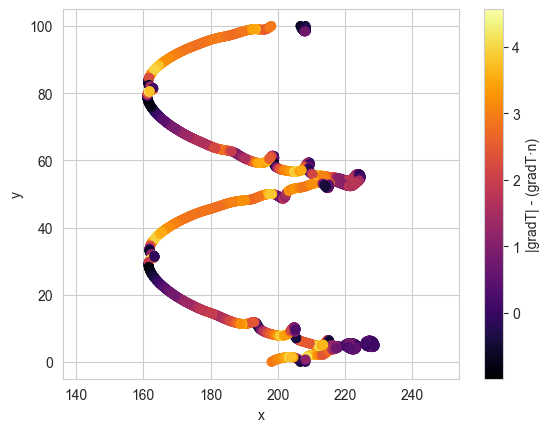

In [22]:
plt.scatter(
    dataset[3.5]["x"],
    dataset[3.5]["y"],
    c = abs(dataset[3.5]["gradT"]) - abs(dataset[3.5]["gradT_normal"]),
    cmap = "inferno"
)
plt.colorbar(label="|gradT| - (gradT·n)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()
